###https://www.sciencedirect.com/science/article/pii/S1568494624002655

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 載入資料
# df = pd.read_csv("female_stroke_data.csv")  # 檔案路徑
df = pd.read_csv("male_stroke_data.csv")  # 檔案路徑

# 分離 features & labels
X = df.drop(columns=["Second_Stroke"])
y = df["Second_Stroke"]

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 標準化（對 DCNN 來說很重要）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data preprocessing done!")

Data preprocessing done!


In [22]:
# !pip3 install geneticalgorithm

 The best solution found:
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.]

 Objective function:
 -0.9508196721311476


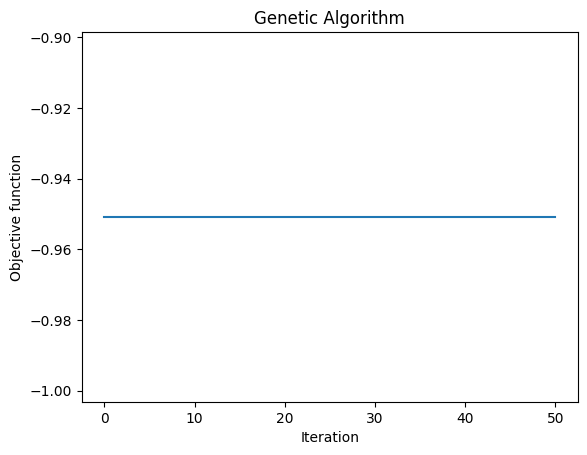

Feature selection done!


In [23]:
from geneticalgorithm import geneticalgorithm as ga
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 適應度函數（用 RF 來評估特徵組合）
def fitness_function(selected_features):
    selected_features = selected_features.astype(bool)
    X_selected = X_train[:, selected_features]

    model = RandomForestClassifier()
    scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')

    return -scores.mean()  # GA 會最小化這個值，所以取負值


from sklearn.feature_selection import VarianceThreshold

# 設定方差閾值（0表示完全相同的特徵將會被刪除）
selector = VarianceThreshold(threshold=0)
X_train_filtered = selector.fit_transform(X_train)
X_test_filtered = selector.transform(X_test)



# 設定 GA 參數
var_bound = np.array([[0, 1]] * X_train.shape[1])  # 每個特徵 0 or 1
algorithm_param = {'max_num_iteration': 50, 'population_size': 20, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': None}

# 進行 GA
model = ga(function=fitness_function, dimension=X_train.shape[1], variable_type='int', variable_boundaries=var_bound, algorithm_parameters=algorithm_param)
model.run()

# 取得最佳特徵組合
best_features = model.output_dict['variable'].astype(bool)
X_train_selected = X_train[:, best_features]
X_test_selected = X_test[:, best_features]

print("Feature selection done!")

In [24]:
from imblearn.over_sampling import SMOTE

# 使用 SMOTE 做 data augmentation
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print("Data augmentation done! New class distribution:", np.bincount(y_train_balanced))

Data augmentation done! New class distribution: [695 695]


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 建立 DCNN 模型
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # 二元分類
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
history = model.fit(X_train_balanced, y_train_balanced, validation_data=(X_test_selected, y_test), epochs=50, batch_size=32)

print("Model training done!")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6399 - loss: 0.7301 - val_accuracy: 0.7772 - val_loss: 0.5876
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7185 - loss: 0.5747 - val_accuracy: 0.8261 - val_loss: 0.5664
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7446 - loss: 0.5319 - val_accuracy: 0.7609 - val_loss: 0.5424
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7800 - loss: 0.4803 - val_accuracy: 0.7826 - val_loss: 0.5310
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7595 - loss: 0.4869 - val_accuracy: 0.7609 - val_loss: 0.4961
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7985 - loss: 0.4342 - val_accuracy: 0.7663 - val_loss: 0.4790
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8100 - loss: 0.4487 - val_accuracy: 0.7772 - val_loss: 0.4992
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7939 - loss: 0.4319 - val_accuracy: 0.7772 - val_loss: 0.4568
Ep

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# 預測
y_pred = (model.predict(X_test_selected) > 0.5).astype(int)

# 評估結果
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

print("Model evaluation done!")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix:
 [[162  13]
 [  6   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       175
           1       0.19      0.33      0.24         9

    accuracy                           0.90       184
   macro avg       0.58      0.63      0.59       184
weighted avg       0.93      0.90      0.91       184

Model evaluation done!
